## Inpainting with trained Wasserstein-GAN

In [1]:
import numpy as np
import torch
import torch.nn as nn
import h5py
from pathlib import Path

from utils.create_data import sample_check
from utils.tools import random_bbox, mask_image, get_config, random_bnd, random_bnd2
from model.networks import Generator

In [2]:
# Parameters
dim = '3D'
iter= '600000'
img_idx = 90
plt_scale = 0.1
perc = 100
rng = np.random.default_rng(0)
# path_orig = Path(__file__).parent.resolve() / 'checkpoints' / 'boundary_1_256'
# exp_path = r'C:\Users\s174370\magfield-prediction\checkpoints\boundary_1_256'
exp_path = r'C:\Users\s174370\magfield-prediction\checkpoints\boundary_1_256'
model = 'in_94_l1'
# model = 'in_96_l1_perc'
# model = 'in_94_sp_gauge'
exp_path = Path(exp_path,model)
print(exp_path)

C:\Users\s174370\magfield-prediction\checkpoints\boundary_1_256\in_94_l1


(3, 256, 256)
hello


<Figure size 640x480 with 0 Axes>

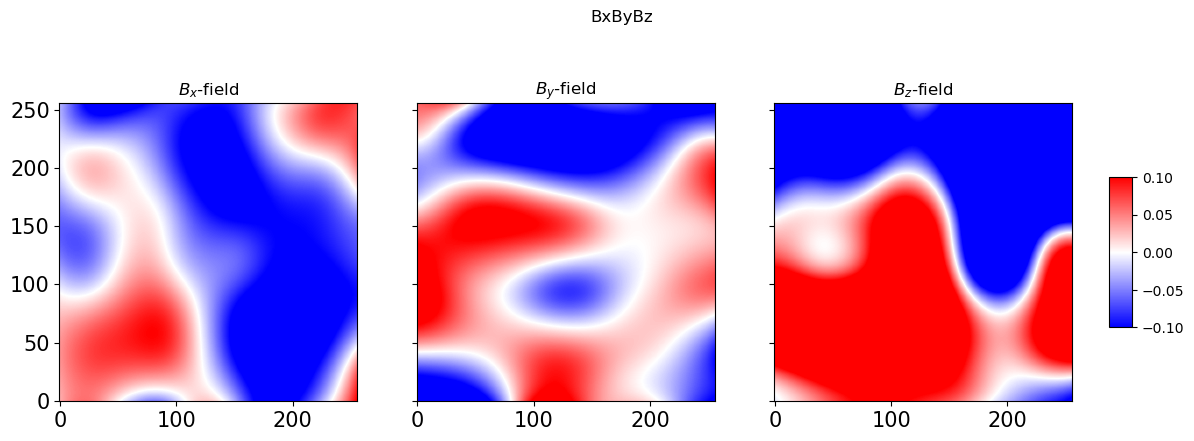

In [3]:
if dim == '2D':
    file = h5py.File('data/magfield_symm_val_256.h5')
    print(file['field'][img_idx,:,:,:].shape)
    field = file['field'][img_idx,:,:,:] 
    sample_check(field, v_max=plt_scale, filename = 'orig_'+model)
    print('hola')
if dim == '3D':
    file = h5py.File('data/magfield_256_large.h5') 
    print(file['field'][img_idx,:,:,:,1].shape)
    field = file['field'][img_idx,:,:,:,1]
    sample_check(field, v_max=plt_scale, filename = 'BxByBz')
    print('hello')

C:\Users\s174370\magfield-prediction\checkpoints\boundary_1_256\in_94_l1\config.yaml
torch.Size([150, 1, 4])
0
(150, 3, 96, 96)
0


<Figure size 640x480 with 0 Axes>

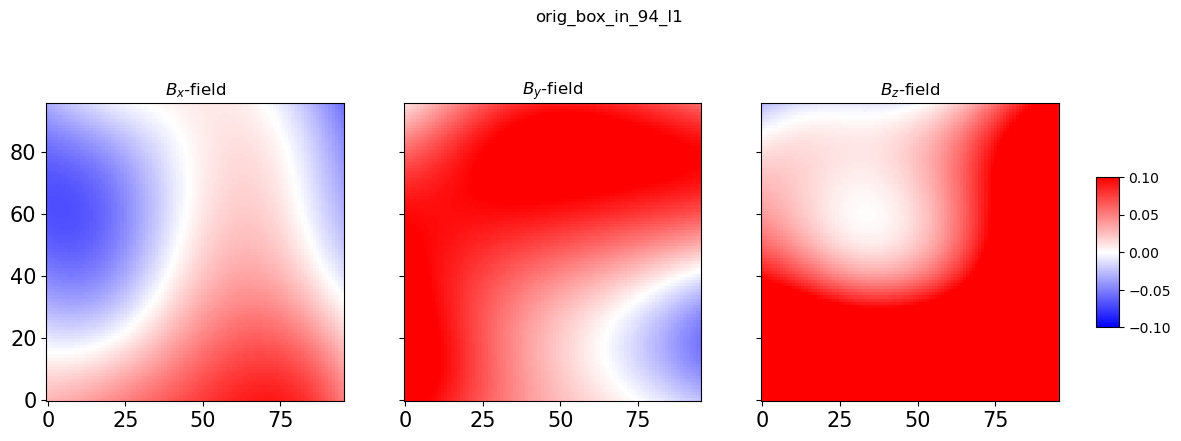

In [4]:
path = Path(exp_path,'config.yaml')
print(path)
# config = get_config(path)
config = get_config(r'C:\Users\s174370\magfield-prediction\checkpoints\boundary_1_256\in_94_l1\config.yaml')
# config = get_config(r'C:\Users\s174370\magfield-prediction\checkpoints\boundary_1_256\in_94_l1_perc\config.yaml')
# bboxes = random_bbox(config, rng=rng)
bbox_list = [[(75, 10, 94, 94)] for _ in range(config['batch_size'])]
bboxes = torch.tensor(bbox_list, dtype=torch.int64)
print(bboxes.shape)
x, mask, orig = mask_image(np.array([field]), bboxes, config, bnd=config['boundary'], perc = perc)
print(np.sum(mask[:,:,-1]==1))
print(x.shape)
# mask = random_bnd(mask, perc)
print(np.sum(mask[:,:,-1]==1))

sample_check(orig[0], v_max=plt_scale, filename = 'orig_box_'+model)


<Figure size 640x480 with 0 Axes>

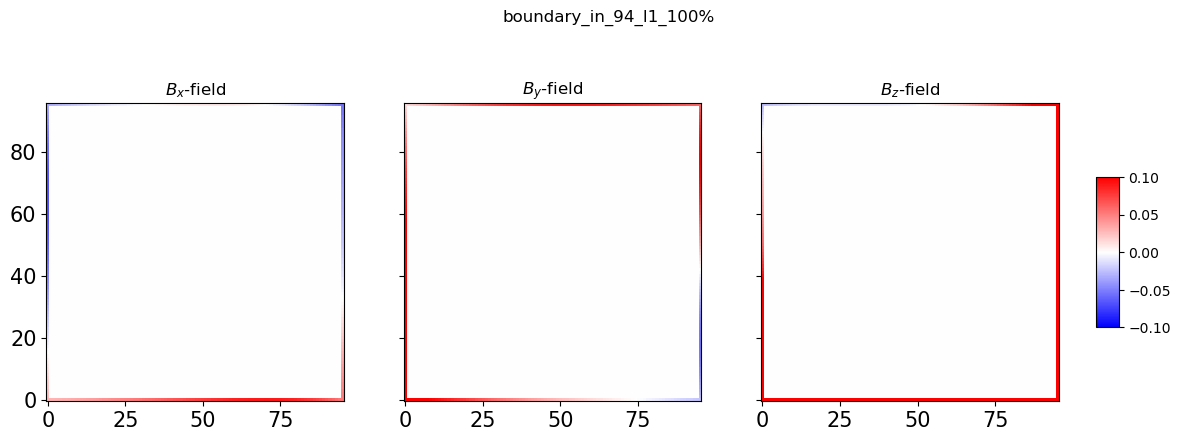

In [5]:
sample_check(x[0], v_max=plt_scale, filename = 'boundary_'+model+'_'+str(perc)+'%')


In [6]:
# last_model_name = exp_path + '/gen_'+str+'.pt')
print(exp_path)
gen= '/gen_00'+iter+'.pt'
last_model_name = r'C:\Users\s174370\magfield-prediction\checkpoints\boundary_1_256\in_94_l1\gen_00600000.pt'
# last_model_name = r'C:\Users\s174370\magfield-prediction\checkpoints\boundary_1_256\in_94_l1_perc\gen_00500000.pt'
print(last_model_name)
# last_model_name = Path(exp_path,'/gen_00'+iter+'.pt')
# Generator(config, coarse_G, use_cuda, device_ids)
netG = Generator(config['netG'], config['coarse_G'], True, [0])
netG.load_state_dict(torch.load(last_model_name))
netG = nn.parallel.DataParallel(netG, device_ids=[0])
corrupt_t = torch.from_numpy(x[0].astype('float32')).cuda().unsqueeze(0)
mask_t = torch.from_numpy(mask[0].astype('float32')).cuda().unsqueeze(0)

# Inference
_, out, _ = netG(corrupt_t, mask_t)



C:\Users\s174370\magfield-prediction\checkpoints\boundary_1_256\in_94_l1
C:\Users\s174370\magfield-prediction\checkpoints\boundary_1_256\in_94_l1\gen_00600000.pt


<Figure size 640x480 with 0 Axes>

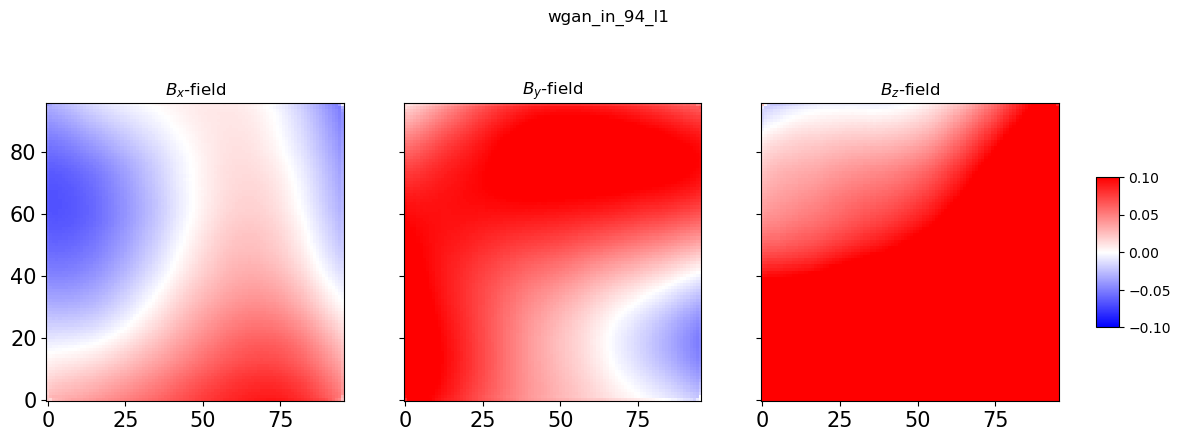

In [7]:
out_np = out.squeeze(0).cpu().data.numpy()
sample_check(out_np, v_max=plt_scale, filename='wgan_'+model)

In [13]:
diff = abs(orig - out_np)
mse_final = np.mean(diff**2)
psnr = 20 * np.log10(np.max(orig) / np.sqrt(mse_final))
mape = 100*(np.abs(np.mean(diff)/np.mean(orig)))

print(np.mean(diff))
print(f"Recon loss: {np.mean(np.abs(diff)):.4f}")
print(f"PSNR: {psnr:.4f} dB")
print(f"MAPE: {mape:.4f} %")


0.011546981
Recon loss: 0.0115
PSNR: 22.8568 dB
MAPE: 18.5544 %


In [9]:
out_stack = torch.from_numpy(out_np)[None, :]

# Div
Hx_x = torch.gradient(out_stack[0,0], dim=1, edge_order=2)[0]
Hy_y = torch.gradient(out_stack[0,1], dim=0, edge_order=2)[0]
if len(out_stack.size()[1:]) > 3 : 
    Hz_z = torch.gradient(out_stack[0,2], dim=2, edge_order=2)[0]
    div_mag = torch.stack([Hx_x, Hy_y, Hz_z], dim=0)[:,:,:,1]
else:
    div_mag = torch.stack([Hx_x, Hy_y], dim=0)
div = torch.mean(torch.abs(div_mag.sum(dim=0)))

#Curl
Hx_y = torch.gradient(out_stack[0,0], dim=0, edge_order=2)[0]
Hy_x = torch.gradient(out_stack[0,1], dim=1, edge_order=2)[0]
if len(out_stack.size()[1:]) > 3 :
    Hx_z = torch.gradient(out_stack[0,0], dim=2, edge_order=2)[0]
    Hy_z = torch.gradient(out_stack[0,1], dim=2, edge_order=2)[0]
    Hz_x = torch.gradient(out_stack[0,2], dim=1, edge_order=2)[0]
    Hz_y = torch.gradient(out_stack[0,2], dim=0, edge_order=2)[0]
    curl_vec = torch.stack([Hz_y - Hy_z, Hx_z - Hz_x, Hy_x - Hx_y], dim=0)[:,:,:,1]
    curl_mag = curl_vec.square().sum(dim=0)
else:
    curl_mag = (Hy_x - Hx_y).square()
curl = torch.mean(curl_mag)

print(f"divergence: {div*1e3:.5f} [mT/px]")
print(f"curl: {curl*1e6:.5f} [\u03BC T/px]")

divergence: 2.05451 [mT/px]
curl: 1.12048 [μ T/px]
